In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba.experimental import jitclass
from numba import njit
from numba import int64, float64
import time

In [2]:
spec = [
    ('sig2', float64),
    ('mu', float64),
    ('T2', float64),  
]

@jitclass(spec)
class Chi2:
    def __init__(self, sig2, T2=np.inf):
        self.sig2 = sig2
        self.mu = 0
        self.T2 = T2


    def raw_moments(self, t, d):
        

        # Calculate exp(), sin() and cos() only once! 
        exp_ = np.exp(-t**2*(self.sig2/2 + 1/self.T2**2) )
        
        sin_ = np.sin(self.mu*t)
        cos_ = np.cos(self.mu*t)

        norm = 1 + (1-2*d)*cos_*exp_
            
        m1 = ( self.mu**2 + self.sig2 + (2*d-1)*(2*t*self.mu*self.sig2*sin_-(self.mu**2+self.sig2-t**2*self.sig2**2)*cos_)*exp_ ) / norm
            
        m2 = ( self.mu**4 + 6*self.mu**2 * self.sig2 + 3*self.sig2**2 \
              + (2*d-1)*( 4*t*self.mu*self.sig2*(self.mu**2+3*self.sig2-t**2*self.sig2**2)*sin_ \
                         - (self.mu**4 + self.mu**2*(6*self.sig2-6*t**2*self.sig2**2) \
                            + self.sig2**2*(3-6*t**2*self.sig2+t**4*self.sig2**2))*cos_ )*exp_ ) / norm
            
        return (m1, m2)
        


    def update_mu_and_sigma(self, t, d):

        m = self.raw_moments(t, d)
        
        sqrt_ = np.sqrt( max(0, 3*m[0]**2 / 2 - m[1]/2 ) )
        
        return ( np.sqrt(sqrt_), m[0]-sqrt_ )
    


    def risk_minimum(self):
        t_opt = 1/np.sqrt(2/self.T2**2+self.sig2)
        
        if t_opt*self.mu >= np.pi/2:
            k = max(np.floor((t_opt*self.mu/np.pi-1/2)), 0)
            return (k+1/2)*np.pi/self.mu
        else:
            return t_opt
    
    def iterate(self, d, t):
        ms = self.update_mu_and_sigma(t, d)

        self.mu = ms[0]
        self.sig2 = ms[1]
    
    
    def var(self):
        return self.sig2

    def stdev(self):
        return np.sqrt(self.var())
    
    def expect(self):
        return self.mu
    
    def reset(self, sig2, T2=np.inf):
        self.sig2 = sig2
        self.mu = 0
        self.T2 = T2
        
@njit()       
def FID(true_w, t, T2):

    # Simulate measurement
    p0 = (1 + np.exp(-(t/T2)**2)*np.cos(true_w*t))/2
    draw = np.random.uniform(0,1)
    d = int(draw > p0)
    
    return d



In [3]:
T2 = np.inf

n_loops = 50
n_reps = 10000

data = np.zeros((3, n_reps, n_loops))

ex = Chi2(0.5**2, T2)

@njit(fastmath=False)
def loop(ex, n_loops, n_reps, T2, data):
    

    i = 0
    while i < n_reps:
        

        true_w = abs(np.random.normal(loc=0, scale=0.5))
        
        if true_w > 1:
            continue
        
        if i in [n_reps//10*k for k in range(1, 10)]:
            print(round(100*i/n_reps), "% completed")
            
        ex.reset(0.5**2, T2)
        for j in range(1,n_loops+1):

            t_opt = ex.risk_minimum()
            

            d = FID(true_w, t_opt, T2)


            ex.iterate(d, t_opt)
            
            
            data[0,i,j-1] = ex.var()
            data[1,i,j-1] = abs(ex.expect()-true_w)
            data[2,i,j-1] = t_opt

            
            
        i += 1

    return data

start = time.time()

data = loop(ex, n_loops, n_reps, T2, data)

end = time.time()

print()
print('Time elapsed:', end-start, 'seconds')

10 % completed
20 % completed
30 % completed
40 % completed
50 % completed
60 % completed
70 % completed
80 % completed
90 % completed

Time elapsed: 1.012160062789917 seconds


/tmp/ipykernel_1150901/3651190863.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


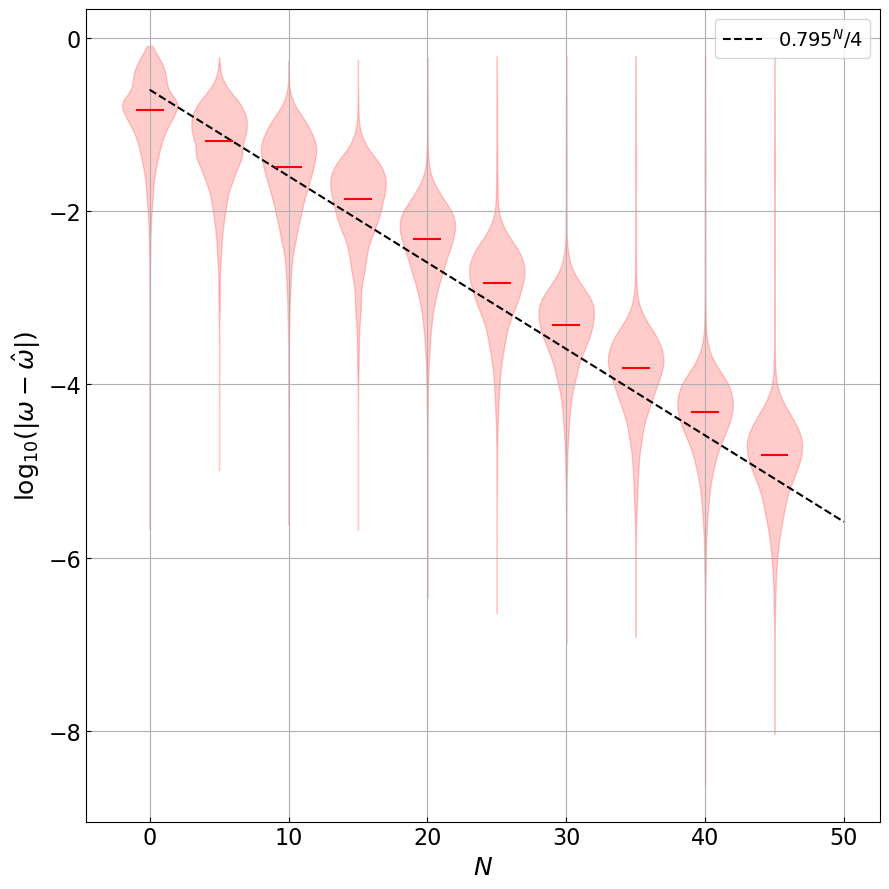

In [4]:
fig, ax1 = plt.subplots(1,1,figsize=(9,9))

# "Linear" guide to the eye (log of an exponential function)
plt.plot(np.arange(51), np.log10(0.25*0.632**(np.arange(51)/2)), ls='--', color='k', label=r'$0.795^{N}/4$')

violin_parts = ax1.violinplot(np.log10(data[1,:,0::5]), 
                              positions=np.arange(50)[0::5], widths=4, showmedians=True, 
                              showextrema=False, showmeans=False, points=100)
for vp in violin_parts['bodies']:
    vp.set_color('red')
    vp.set_alpha(0.2)
violin_parts['cmedians'].set_color('red')


ax1.tick_params(labelsize=16, direction='in')
ax1.set_xlabel(r'$N$', fontsize=18)
ax1.set_ylabel(r'$\log_{10}(|\omega-\hat{\omega}|)$', fontsize=18)
ax1.grid()
ax1.legend(fontsize=14)
fig.tight_layout()
fig.show()